In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
import os
num_skipped = 0
for folder_name in ("cats", "dogs"):
    folder_path = os.path.join("test", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [6]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "train",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 144 files belonging to 2 classes.
Using 116 files for training.
Using 28 files for validation.


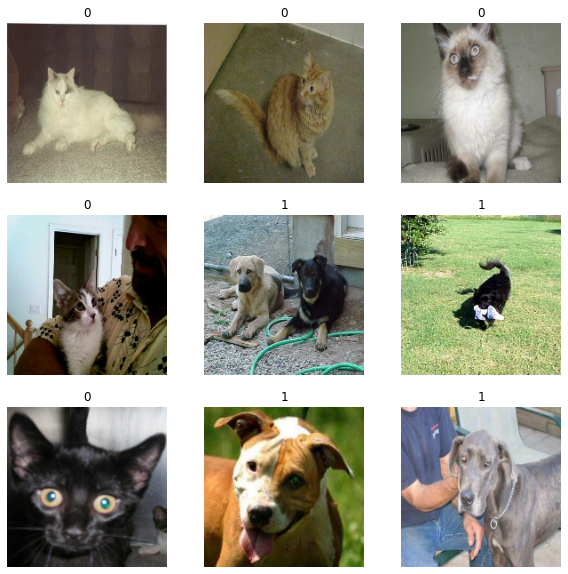

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

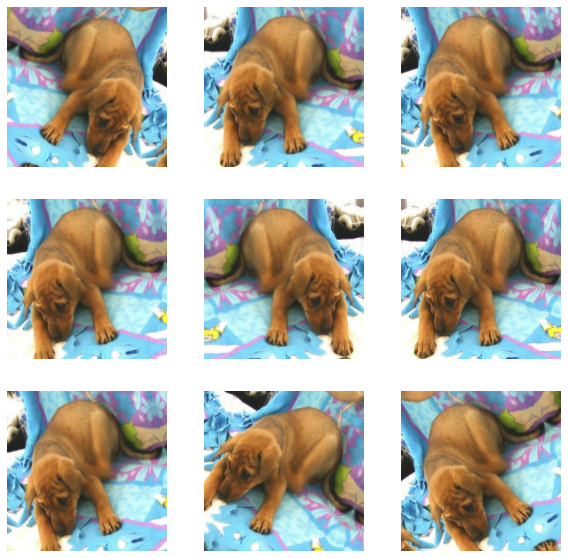

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [10]:
input_shape=(64,64,1)
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

In [11]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [12]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.GlobalAveragePooling2D()(x)
#    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
#    x = layers.Activation("relu")(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)
model

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 90, 90, 128)       3584      
                                                                 
 batch_normalization (BatchN  (None, 90, 90, 128)      512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 90, 90, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 128)      0         
 )                                                           

In [26]:
epochs = 15
batch_size= 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.1),
    loss="mse",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/15
1/1 [==============================] - 5s 5s/step - loss: 0.2717 - accuracy: 0.5000 - val_loss: 0.2480 - val_accuracy: 0.6786
Epoch 2/15
1/1 [==============================] - 4s 4s/step - loss: 0.2597 - accuracy: 0.5517 - val_loss: 0.2515 - val_accuracy: 0.3571
Epoch 3/15
1/1 [==============================] - 4s 4s/step - loss: 0.2728 - accuracy: 0.5259 - val_loss: 0.2530 - val_accuracy: 0.3214
Epoch 4/15
1/1 [==============================] - 4s 4s/step - loss: 0.2640 - accuracy: 0.4914 - val_loss: 0.2529 - val_accuracy: 0.3214
Epoch 5/15
1/1 [==============================] - 4s 4s/step - loss: 0.2262 - accuracy: 0.6293 - val_loss: 0.2562 - val_accuracy: 0.3214
Epoch 6/15
1/1 [==============================] - 4s 4s/step - loss: 0.2342 - accuracy: 0.6293 - val_loss: 0.2543 - val_accuracy: 0.3214
Epoch 7/15
1/1 [==============================] - 4s 4s/step - loss: 0.2485 - accuracy: 0.5690 - val_loss: 0.2574 - val_accuracy: 0.3214
Epoch 8/15
1/1 [=========================

In [13]:
model.save("mymodel.model")

INFO:tensorflow:Assets written to: mymodel.model\assets


INFO:tensorflow:Assets written to: mymodel.model\assets


In [15]:
#test the  model
img = keras.preprocessing.image.load_img(
    "kinyua.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

1/1 [==============================] - 0s 49ms/step
This image is 49.73% cat and 50.27% dog.
